In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
import surprise as sp
import time

In [2]:
UsersDF = pd.read_csv('dataset/users_cleaned.csv')
AnimesDF = pd.read_csv('dataset/anime_cleaned.csv')
ScoresDF = pd.read_csv('dataset/animelists_cleaned.csv')

In [3]:
genres = AnimesDF['genre'].str.split(',').explode()
genres = genres.str.strip()
unique_genres = genres.unique()
print(unique_genres)

print(AnimesDF.info())
AnimesDF.head()

['Comedy' 'Supernatural' 'Romance' 'Shounen' 'Parody' 'School' 'Magic'
 'Shoujo' 'Drama' 'Fantasy' 'Kids' 'Action' 'Music' 'Slice of Life'
 'Josei' 'Harem' 'Shounen Ai' 'Adventure' 'Super Power' 'Sci-Fi' 'Ecchi'
 'Seinen' 'Martial Arts' 'Game' 'Sports' 'Demons' 'Historical' 'Horror'
 'Mystery' 'Psychological' 'Vampire' 'Mecha' 'Military' 'Space' 'Samurai'
 'Thriller' 'Hentai' 'Yaoi' 'Shoujo Ai' 'Police' 'Cars' 'Dementia' 'Yuri'
 nan]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6668 entries, 0 to 6667
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   anime_id         6668 non-null   int64  
 1   title            6668 non-null   object 
 2   title_english    3438 non-null   object 
 3   title_japanese   6663 non-null   object 
 4   title_synonyms   4481 non-null   object 
 5   image_url        6666 non-null   object 
 6   type             6668 non-null   object 
 7   source           6668 non-null   obj

,anime_id,title,title_english,title_japanese,title_synonyms,image_url,type,source,episodes,status,...,broadcast,related,producer,licensor,studio,genre,opening_theme,ending_theme,duration_min,aired_from_year
0,11013,Inu x Boku SS,Inu X Boku Secret Service,妖狐×僕SS,Youko x Boku SS,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,12,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 17207, 'type': 'man...","Aniplex, Square Enix, Mainichi Broadcasting Sy...",Sentai Filmworks,David Production,"Comedy, Supernatural, Romance, Shounen","['""Nirvana"" by MUCC']","['#1: ""Nirvana"" by MUCC (eps 1, 11-12)', '#2: ...",24.0,2012.0
1,2104,Seto no Hanayome,My Bride is a Mermaid,瀬戸の花嫁,The Inland Sea Bride,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,26,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 759, 'type': 'manga...","TV Tokyo, AIC, Square Enix, Sotsu",Funimation,Gonzo,"Comedy, Parody, Romance, School, Shounen","['""Romantic summer"" by SUN&LUNAR']","['#1: ""Ashita e no Hikari (明日への光)"" by Asuka Hi...",24.0,2007.0
2,5262,Shugo Chara!! Doki,Shugo Chara!! Doki,しゅごキャラ！！どきっ,"Shugo Chara Ninenme, Shugo Chara! Second Year",https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,51,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 101, 'type': 'manga...","TV Tokyo, Sotsu",NaN,Satelight,"Comedy, Magic, School, Shoujo","['#1: ""Minna no Tamago (みんなのたまご)"" by Shugo Cha...","['#1: ""Rottara Rottara (ロッタラ ロッタラ)"" by Buono! ...",24.0,2008.0
3,721,Princess Tutu,Princess Tutu,プリンセスチュチュ,NaN,https://myanimelist.cdn-dena.com/images/anime/...,TV,Original,38,Finished Airing,...,Fridays at Unknown,"{'Adaptation': [{'mal_id': 1581, 'type': 'mang...","Memory-Tech, GANSIS, Marvelous AQL",ADV Films,Hal Film Maker,"Comedy, Drama, Magic, Romance, Fantasy","['""Morning Grace"" by Ritsuko Okazaki']","['""Watashi No Ai Wa Chiisaikeredo"" by Ritsuko ...",16.0,2002.0
4,12365,Bakuman. 3rd Season,Bakuman.,バクマン。,Bakuman Season 3,https://myanimelist.cdn-dena.com/images/anime/...,TV,Manga,25,Finished Airing,...,Unknown,"{'Adaptation': [{'mal_id': 9711, 'type': 'mang...","NHK, Shueisha",NaN,J.C.Staff,"Comedy, Drama, Romance, Shounen","['#1: ""Moshimo no Hanashi (もしもの話)"" by nano.RIP...","['#1: ""Pride on Everyday"" by Sphere (eps 1-13)...",24.0,2012.0


In [4]:
print(UsersDF.info())
UsersDF.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108711 entries, 0 to 108710
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   username                  108710 non-null  object 
 1   user_id                   108711 non-null  int64  
 2   user_watching             108711 non-null  int64  
 3   user_completed            108711 non-null  int64  
 4   user_onhold               108711 non-null  int64  
 5   user_dropped              108711 non-null  int64  
 6   user_plantowatch          108711 non-null  int64  
 7   user_days_spent_watching  108711 non-null  float64
 8   gender                    108711 non-null  object 
 9   location                  108706 non-null  object 
 10  birth_date                108711 non-null  object 
 11  access_rank               0 non-null       float64
 12  join_date                 108711 non-null  object 
 13  last_online               108711 non-null  o

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,karthiga,2255153,3,49,1,0,0,55.091667,Female,"Chennai, India",1990-04-29 00:00:00,NaN,2013-03-03 00:00:00,2014-02-04 01:32:00,7.43,0.0,3391
1,Damonashu,37326,45,195,27,25,59,82.574306,Male,"Detroit,Michigan",1991-08-01 00:00:00,NaN,2008-02-13 00:00:00,2017-07-10 06:52:54,6.15,6.0,4903
2,bskai,228342,25,414,2,5,11,159.483333,Male,"Nayarit, Mexico",1990-12-14 00:00:00,NaN,2009-08-31 00:00:00,2014-05-12 16:35:00,8.27,1.0,9701
3,terune_uzumaki,327311,5,5,0,0,0,11.394444,Female,"Malaysia, Kuantan",1998-08-24 00:00:00,NaN,2010-05-10 00:00:00,2012-10-18 19:06:00,9.70,6.0,697
4,Bas_G,5015094,35,114,6,20,175,30.458333,Male,"Nijmegen, Nederland",1999-10-24 00:00:00,NaN,2015-11-26 00:00:00,2018-05-10 20:53:37,7.86,0.0,1847


In [5]:
print(ScoresDF.info())
ScoresDF.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31284030 entries, 0 to 31284029
Data columns (total 11 columns):
 #   Column               Dtype  
---  ------               -----  
 0   username             object 
 1   anime_id             int64  
 2   my_watched_episodes  int64  
 3   my_start_date        object 
 4   my_finish_date       object 
 5   my_score             int64  
 6   my_status            int64  
 7   my_rewatching        float64
 8   my_rewatching_ep     int64  
 9   my_last_updated      object 
 10  my_tags              object 
dtypes: float64(1), int64(5), object(5)
memory usage: 2.6+ GB
None


,username,anime_id,my_watched_episodes,my_start_date,my_finish_date,my_score,my_status,my_rewatching,my_rewatching_ep,my_last_updated,my_tags
0,karthiga,21,586,0000-00-00,0000-00-00,9,1,NaN,0,2013-03-03 10:52:53,NaN
1,karthiga,59,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-10 13:54:51,NaN
2,karthiga,74,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-04-27 16:43:35,NaN
3,karthiga,120,26,0000-00-00,0000-00-00,7,2,NaN,0,2013-03-03 10:53:57,NaN
4,karthiga,178,26,0000-00-00,0000-00-00,7,2,0.0,0,2013-03-27 15:59:13,NaN


Убираем из таблицы ScoresDF ненужные столбцы

In [6]:
ScoresDF = ScoresDF[['username', 'anime_id', 'my_score', 'my_status']]

Проверяем диапазон доступных рейтинговых оценок

In [7]:
lower_rating = ScoresDF['my_score'].min()
upper_rating = ScoresDF['my_score'].max()
print('Диапазон оценок: {0} до {1}'.format(lower_rating, upper_rating))

Диапазон оценок: 0 до 10


Считаем, сколько раз каждый пользователь оценил какой-либо тайтл, т.е. сколько оценок он поставил за всё время

In [8]:
UsersAndScores = ScoresDF['username'].value_counts().reset_index().rename(columns={"username": "animes_rated", "index": "username"})
UsersAndScores.head(10)

,username,animes_rated
0,Exxorn,6536
1,uemmega,6367
2,JakCooper2,5923
3,DeadlyKizuna,5912
4,KanaenuYume,5234
5,NightTerror,5151
6,DesireDestiny,5062
7,Cafer,4777
8,Dragonflyk,4632
9,Virali,4524


In [9]:
UsersSampled = UsersDF.sample(frac = .01, random_state = 2)
UsersSampled.head()

,username,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
48731,Saperella,98375,21,162,0,4,28,34.550000,Male,"York, UK",1989-08-31 00:00:00,NaN,2008-09-25 00:00:00,2010-07-22 05:41:00,7.94,4.0,2131
35191,Inugirlz,207889,52,908,227,164,300,301.467361,Female,Where Maple Leaves Reside,1994-04-04 00:00:00,NaN,2009-07-14 00:00:00,2018-05-19 14:23:41,7.16,58.0,18796
77699,Luu-Senpai,5393511,10,663,0,0,19,177.401111,Male,Buenos Aires,1991-05-23 00:00:00,NaN,2016-05-07 00:00:00,2018-04-27 04:38:21,7.72,0.0,11129
95207,OzzyOtaku,607875,16,342,0,76,69,91.565278,Male,TEXAS,1989-01-24 00:00:00,NaN,2011-09-19 00:00:00,2018-05-20 18:51:57,7.77,18.0,5987
85049,Ahlala,485718,1,67,29,8,32,37.024306,Female,Philippines,1991-04-10 00:00:00,NaN,2011-05-12 00:00:00,2017-07-27 01:10:00,8.31,27.0,2251


In [10]:
UsersAndScoresSampled = pd.merge(UsersAndScores, UsersSampled, left_on = 'username', right_on = 'username', how = 'inner')
UsersAndScoresSampled.head()

,username,animes_rated,user_id,user_watching,user_completed,user_onhold,user_dropped,user_plantowatch,user_days_spent_watching,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes
0,Darkvoid,3976,280949,231,2404,133,12,3216,314.544884,Male,Germany,1980-10-05 00:00:00,NaN,2010-01-10 00:00:00,2018-05-11 19:50:31,7.80,0.0,20038
1,Red_Ranger_Wien,2881,615007,26,1361,10,0,2468,239.585671,Male,"Starkville, Mississippi",1993-07-24 00:00:00,NaN,2011-09-20 00:00:00,2018-05-15 02:58:34,6.74,0.0,16678
2,werewolfgirl1995,2591,212929,41,31,213,0,2790,13.791667,Female,"Pittsburgh,Pensylvania",1995-03-02 00:00:00,NaN,2009-07-25 00:00:00,2018-04-24 07:55:06,9.05,0.0,825
3,gust11,2200,1605329,174,958,5,0,1256,206.283912,Male,The Hyperdimension,2000-01-19 00:00:00,NaN,2012-10-08 00:00:00,2017-12-24 02:52:46,8.24,39.0,13163
4,RyokoAyekaLover,2106,81624,359,573,1,0,1763,242.313565,Male,"United States,New York",1991-06-11 00:00:00,NaN,2008-07-31 00:00:00,2018-05-20 03:12:24,0.00,21.0,15740


Группировка пользователей с одинаковым числом выставленных рейтингов

In [11]:
UserRatedsAggregated = UsersAndScoresSampled['animes_rated'].value_counts().reset_index().rename(columns={"animes_rated": "group_size", "index": "animes_rated"}).sort_values(by=['animes_rated']).reset_index(drop=True)
UserRatedsAggregated.head()

,animes_rated,group_size
0,1,2
1,2,4
2,3,7
3,4,3
4,5,6


Подсчет кол-ва оценок для каждого аниме

In [12]:
RatedsPerAnime = ScoresDF['anime_id'].value_counts().reset_index().rename(columns={"anime_id": "number_of_users", "index": "anime_id"})
RatedsPerAnime.head()

,anime_id,number_of_users
0,1535,81332
1,1575,67721
2,226,64486
3,5114,63649
4,4224,63278


Группировка аниме, которые оценило одинаковое количество пользователей

In [13]:
AnimeRatedsAggregated = RatedsPerAnime['number_of_users'].value_counts().reset_index().rename(columns={"number_of_users": "group_size", "index": "number_of_users"}).sort_values(by=['number_of_users'])
AnimeRatedsAggregated.head(n = 30)

,number_of_users,group_size
331,1,3
27,2,11
25,3,11
23,4,12
6,5,16
18,6,13
14,7,14
7,8,16
0,9,22
2,10,21


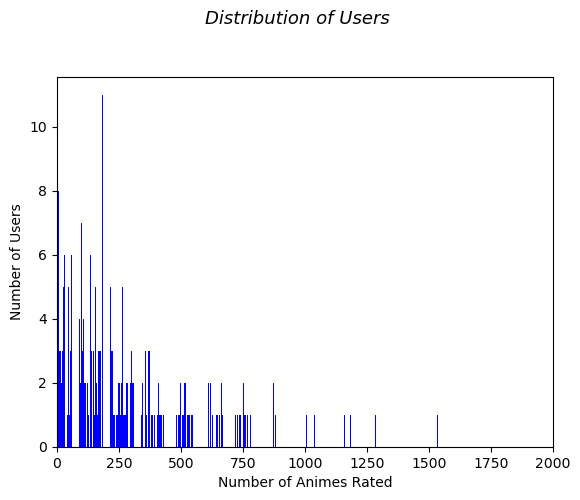

In [14]:
plt.bar(UserRatedsAggregated['animes_rated'], UserRatedsAggregated['group_size'], color='blue')

plt.suptitle("Distribution of Users", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.xlabel('Number of Animes Rated')
plt.ylabel('Number of Users')

plt.xlim(left=0, right=2000)

plt.show()

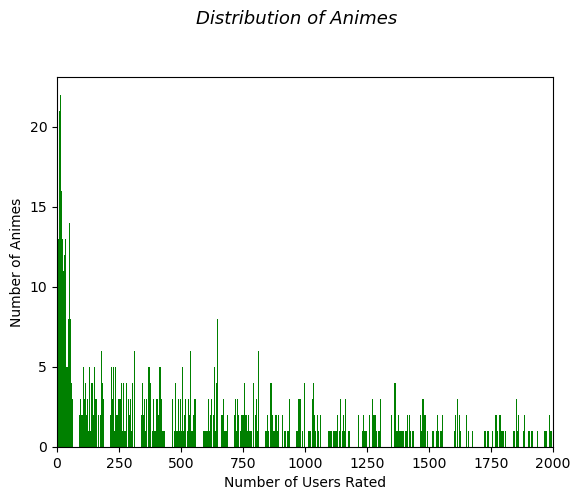

In [15]:
plt.bar(AnimeRatedsAggregated['number_of_users'], AnimeRatedsAggregated['group_size'], color='green')

plt.suptitle("Distribution of Animes", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.xlabel('Number of Users Rated')
plt.ylabel('Number of Animes')

plt.xlim(left=0, right=2000)

plt.show()

Чтобы разобраться с потенциальной проблемой *Cold-start*, просто избавимся от всех пользователей с недостаточным послужным списком.
Аналогично поступим с тайтлами, у которых недостаточно зрительских оценок.

In [16]:
UserRatedsCutten = UsersAndScoresSampled[UsersAndScoresSampled['animes_rated'] >= 10]
AnimeRatedsCutten = RatedsPerAnime[RatedsPerAnime['number_of_users'] >= 10]

ScoresDFHotStart = pd.merge(ScoresDF, UserRatedsCutten, left_on = 'username', right_on = 'username', how = 'inner')
ScoresDFHotStart = pd.merge(ScoresDFHotStart, AnimeRatedsCutten, left_on = 'anime_id', right_on = 'anime_id', how = 'inner')
ScoresDFHotStart.head()

,username,anime_id,my_score,my_status,animes_rated,user_id,user_watching,user_completed,user_onhold,user_dropped,...,gender,location,birth_date,access_rank,join_date,last_online,stats_mean_score,stats_rewatched,stats_episodes,number_of_users
0,Tomoki-sama,21,9,3,515,1933206,10,348,15,28,...,Male,"SC, Brasil",1996-06-01 00:00:00,NaN,2012-12-22 00:00:00,2018-05-10 20:28:44,8.48,8.0,6175,45118
1,brunomp,21,0,1,138,4437072,2,133,0,0,...,Male,"Pernambuco, Brasil",1996-09-29 00:00:00,NaN,2015-01-21 00:00:00,2018-05-16 20:48:09,8.42,0.0,4060,45118
2,Mukkashi,21,8,4,521,1425283,13,327,26,23,...,Male,Saudi Arabia,1996-07-17 00:00:00,NaN,2012-07-29 00:00:00,2018-05-18 01:28:51,7.43,0.0,7030,45118
3,SocialAwkward,21,10,1,313,441230,2,214,6,9,...,Female,Somewhere over the Rainbow,2000-01-24 00:00:00,NaN,2011-01-28 00:00:00,2017-10-23 10:04:52,8.65,25.0,4692,45118
4,crazybela,21,10,1,232,217138,72,86,35,0,...,Female,Brazil,1989-10-05 00:00:00,NaN,2009-08-06 00:00:00,2014-09-25 14:45:00,7.63,0.0,2656,45118


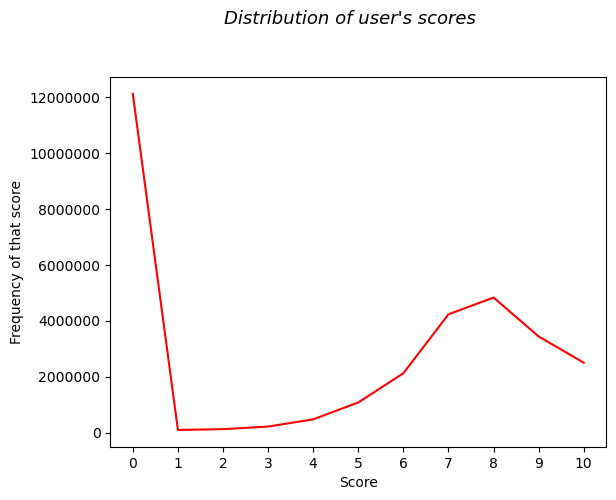

In [17]:
AnimeRates = ScoresDF['my_score'].value_counts().reset_index().sort_values('index')
plt.plot('index', 'my_score', data = AnimeRates, color = 'red')
plt.suptitle("Distribution of user's scores", fontsize=13, fontweight=0, color='black', style='italic', y=1.02)
plt.xticks(np.arange(11))
plt.ticklabel_format(axis = 'y', style = 'plain')
plt.xlabel('Score')
plt.ylabel('Frequency of that score')
plt.show()

In [18]:
print('Размер изначального датафрейма составлял {0} записей. Размер нового составляет {1} строк.'.format(ScoresDF['username'].count(), ScoresDFHotStart['username'].count()))

Размер изначального датафрейма составлял 31283787 записей. Размер нового составляет 324206 строк.


# Метрики

In [19]:
def precision_recall_at_k(predictions, k=10, threshold=7):

    # Отображаем все предикты на соответствующих юзеров
    # Predictions: взвращает список внутри кортежа с 5 полями: User_ID, Item_ID, True_ID, Est_ID, Details
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))
    # Создаем словарь, где глючем будет имя юзера, а значениями - предрлагаемая оценка и реальная
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # сортируем оценки юзеров по их предролагаемым оценкам
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Количество потенциально интересных тайтлов для юзера
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Кол-во порекомендованных тайтлов из топа k оценок
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Кол-во тайтлов, являющихся потенциально интересными, которые порекомендовали
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: доля порекомендованных и потенциально интересных тайтлов ко всем порекомендованным
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: доля порекомендованных и потенциально интересных тайтлов ко всем потенциально интересным
        recalls[uid] = n_rel_and_rec_k /  n_rel if n_rel != 0 else 1

    return precisions, recalls

# user-based filtering

In [20]:
random_state = 55
reader = sp.Reader(rating_scale=(0, 10))
data = sp.Dataset.load_from_df(ScoresDFHotStart[['username', 'anime_id', 'my_score']], reader)
trainset, testset = sp.model_selection.train_test_split(data, test_size=.25, random_state = random_state)
analysis = defaultdict(list)

test_dict = {
    'SVD': sp.SVD(random_state=random_state),
    'SlopeOne': sp.SlopeOne(),
    'NMF': sp.NMF(random_state=random_state),
    'NormalPredictor': sp.NormalPredictor(),
    'KNNBaseline': sp.KNNBaseline(random_state=random_state),
    'KNNBasic': sp.KNNBasic(random_state=random_state),
    'KNNWithMeans': sp.KNNWithMeans(random_state=random_state),
    'KNNWithZScore': sp.KNNWithZScore(random_state=random_state),
    'BaselineOnly': sp.BaselineOnly(),
    'CoClustering': sp.CoClustering(random_state=random_state)
}

for key, value in test_dict.items():
    start = time.time()    
    value.fit(trainset)
    predictions = value.test(testset)

    rmse = sp.accuracy.rmse(predictions)
    precisions, recalls = precision_recall_at_k(predictions, k=10, threshold= 7)
    precision_avg = sum(prec for prec in precisions.values()) / len(precisions)
    recall_avg = sum(rec for rec in recalls.values()) / len(recalls)

    analysis[value] = (key, rmse, precision_avg, recall_avg, time.time() - start)

print(analysis)


RMSE: 3.5273
RMSE: 3.2536
RMSE: 3.3827
RMSE: 5.1159
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2133
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.3713
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2402
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 3.2435
Estimating biases using als...
RMSE: 3.2438
RMSE: 3.3002
defaultdict(<class 'list'>, {<surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000002D841052A10>: ('SVD', 3.5272999103419918, 0.7679063644688627, 0.23631672518953883, 4.556737899780273), <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000002D84076D5D0>: ('SlopeOne', 3.2535936988117875, 0.899965659340658, 0.18205016943834892, 43.27197003364563), <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000002D84100C190>: ('NMF', 3.3827020335591182, 0.8042933455433436,

In [21]:
analysis_df = pd.DataFrame.from_dict(analysis, orient = 'index', columns = ['Algorithm', 'RMSE', 'Precision@10', 'Recall', 'Time to run (in seconds)']).reset_index()

analysis_df = analysis_df[['Algorithm', 'RMSE', 'Precision@10', 'Recall', 'Time to run (in seconds)']]
analysis_df = analysis_df.sort_values(by=['Precision@10'], ascending = False)
analysis_df['RMSE^-1'] = analysis_df['RMSE'] ** -1
analysis_df.head(n = 15)

,Algorithm,RMSE,Precision@10,Recall,Time to run (in seconds),RMSE^-1
8,BaselineOnly,3.243777,0.919489,0.148350,1.077915,0.308283
4,KNNBaseline,3.213338,0.906526,0.176099,17.020399,0.311203
1,SlopeOne,3.253594,0.899966,0.182050,43.271970,0.307352
6,KNNWithMeans,3.240166,0.895986,0.193797,15.967306,0.308626
9,CoClustering,3.300234,0.873900,0.215972,9.379930,0.303009
7,KNNWithZScore,3.243515,0.864266,0.212017,15.940579,0.308307
5,KNNBasic,3.371294,0.831502,0.219416,15.313079,0.296622
2,NMF,3.382702,0.804293,0.192513,7.629305,0.295622
0,SVD,3.527300,0.767906,0.236317,4.556738,0.283503
3,NormalPredictor,5.115879,0.548058,0.199460,0.820675,0.195470


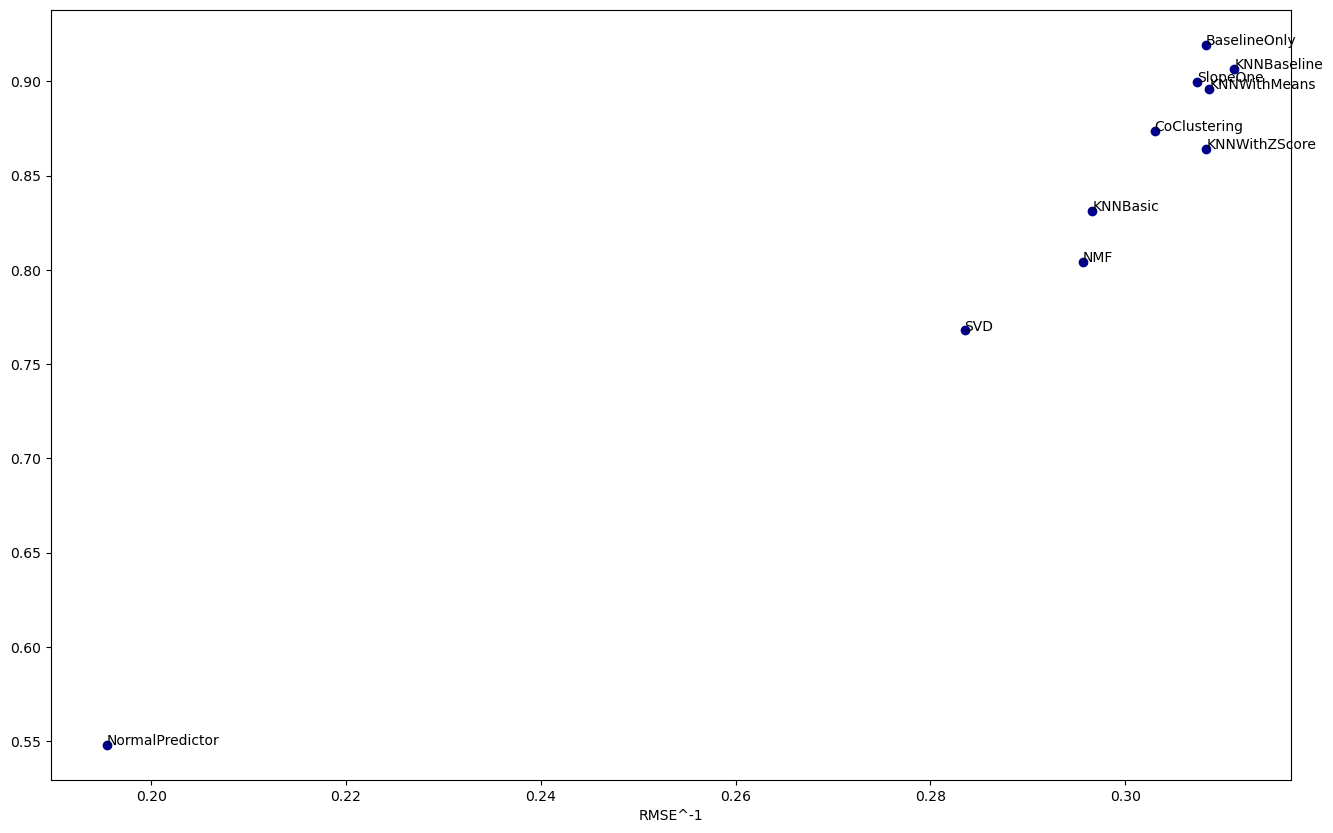

In [22]:
ax = analysis_df.set_index('RMSE^-1')['Precision@10'].plot(style='o', c = 'DarkBlue', figsize = (16, 10))
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(analysis_df['RMSE^-1'], analysis_df['Precision@10'], analysis_df['Algorithm'], ax)

In [23]:
als_param_grid = {'bsl_options': {'method': ['als'],
                              'reg_i': [5, 10, 15],
                              'reg_u': [10, 15, 20],
                              'n_epochs': [5, 10, 15, 20]
                              }
              }

sgd_param_grid = {'bsl_options': {'method': ['sgd'],
                              'reg': [0.01, 0.02, 0.03],
                              'n_epochs': [5, 10, 15, 20],
                              'learning_rate' : [0.001, 0.005, 0.01]
                              }
              }
    
als_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, als_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

sgd_gs = sp.model_selection.GridSearchCV(sp.BaselineOnly, sgd_param_grid, measures=['rmse'], cv = 3, joblib_verbose = 0)

In [24]:
als_gs.fit(data)
sgd_gs.fit(data)

# лучшая RMSE ALS оценка
print(als_gs.best_score['rmse'])

# комбинация параметров для RMSE ALS с наилучшей оценкой
print(als_gs.best_params['rmse'])

# лучшая RMSE SGD оценка
print(sgd_gs.best_score['rmse'])

# комбинация параметров для RMSE SGD с наилучшей оценкой
print(sgd_gs.best_params['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

In [25]:
# best_params = {'bsl_options': {'method': 'sgd', 'reg': 0.01, 'n_epochs': 20, 'learning_rate': 0.005}}
trainset = data.build_full_trainset()
# algo = sp.BaselineOnly(**best_params)
algo = sp.BaselineOnly()
algo.fit(trainset)
testset = trainset.build_anti_testset()
predictions = algo.test(testset)
    
last_predictions = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
last_predictions.drop('rui', inplace = True, axis = 1)
last_predictions.head()

Estimating biases using als...


,uid,iid,est,details
0,Tomoki-sama,269,7.017301,{'was_impossible': False}
1,Tomoki-sama,1735,7.004074,{'was_impossible': False}
2,Tomoki-sama,47,7.092532,{'was_impossible': False}
3,Tomoki-sama,270,6.210099,{'was_impossible': False}
4,Tomoki-sama,442,6.543776,{'was_impossible': False}


In [26]:
last_predictions.shape

(5993623, 4)

In [27]:
def bringing_first_n_values(df, uid, n=10):
    df = df[df['uid'] == uid].nlargest(n, 'est')[['uid', 'iid', 'est']]
    df = pd.merge(df, AnimesDF, left_on = 'iid', right_on = 'anime_id', how = 'left')
    return df[['uid', 'est', 'title', 'genre']]

In [28]:
bringing_first_n_values(last_predictions, 'Tomoki-sama')

,uid,est,title,genre
0,Tomoki-sama,8.050706,Howl no Ugoku Shiro,"Adventure, Drama, Fantasy, Romance"
1,Tomoki-sama,7.910537,Mononoke Hime,"Action, Adventure, Fantasy"
2,Tomoki-sama,7.845694,Clannad: After Story,"Slice of Life, Comedy, Supernatural, Drama, Ro..."
3,Tomoki-sama,7.778978,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar..."
4,Tomoki-sama,7.743585,Kimi no Na wa.,"Supernatural, Drama, Romance, School"
5,Tomoki-sama,7.696071,Shelter,"Sci-Fi, Music"
6,Tomoki-sama,7.593356,Final Fantasy VII: Advent Children,"Action, Super Power, Fantasy"
7,Tomoki-sama,7.593259,"Clannad: Mou Hitotsu no Sekai, Tomoyo-hen","Drama, Romance, School, Slice of Life"
8,Tomoki-sama,7.545917,One Piece 3D2Y: Ace no shi wo Koete! Luffy Nak...,"Adventure, Comedy, Fantasy, Shounen"
9,Tomoki-sama,7.541329,Tenkuu no Shiro Laputa,"Adventure, Fantasy, Romance, Sci-Fi"


# item-based filtering

In [29]:
sim_options = {'name': 'pearson_baseline', 'user_based': False}
algo_items = sp.KNNBaseline(sim_options=sim_options)
algo_items.fit(trainset)

# cv_results = cross_validate(algo_items, data, measures=['RMSE'], cv=5, verbose=True)
# avg_rmse = np.mean(cv_results['test_rmse'])
# predictions = algo_items.test(testset)
# accuracy.rmse(predictions, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [30]:
def get_item_recommendations(anime_title, anime_id=100000, k=10):
    if anime_id == 100000:     
        anime_id = AnimesDF[AnimesDF['title'] == anime_title]['anime_id'].iloc[0]
        
    iid = algo_items.trainset.to_inner_iid(anime_id)
    neighbors = algo_items.get_neighbors(iid, k=k)
    raw_neighbors = (algo.trainset.to_raw_iid(inner_id) for inner_id in neighbors)
    df = pd.DataFrame(raw_neighbors, columns = ['Anime_ID'])
    df = pd.merge(df, AnimesDF, left_on = 'Anime_ID', right_on = 'anime_id', how = 'left')
    
    # Calculate similarity scores between input anime and its recommended neighbors
    similarity_scores = []
    for neighbor_id in neighbors:
        similarity_scores.append(algo_items.sim[iid, neighbor_id])

    # Add similarity scores to the DataFrame
    df['Similarity'] = similarity_scores
    
    return df[['Anime_ID', 'title', 'genre', 'Similarity']]

In [31]:
get_item_recommendations('Dragon Ball Z', k=30)

,Anime_ID,title,genre,Similarity
0,223,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",0.441324
1,225,Dragon Ball GT,"Action, Adventure, Comedy, Fantasy, Magic, Sci...",0.319987
2,527,Pokemon,"Action, Adventure, Comedy, Kids, Fantasy",0.225328
3,552,Digimon Adventure,"Action, Adventure, Comedy, Fantasy, Kids",0.220845
4,1709,Pokemon: Mewtwo! Ware wa Koko ni Ari,"Action, Adventure, Comedy, Drama, Fantasy, Kids",0.197073
5,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",0.195062
6,530,Bishoujo Senshi Sailor Moon,"Demons, Magic, Romance, Shoujo",0.186007
7,43,Ghost in the Shell,"Action, Sci-Fi, Police, Psychological, Mecha, ...",0.185490
8,481,Yu☆Gi☆Oh! Duel Monsters,"Adventure, Game, Shounen",0.182112
9,986,Dragon Ball Z Special 1: Tatta Hitori no Saish...,"Adventure, Comedy, Fantasy, Sci-Fi, Shounen",0.182005


# Content-based

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3),
            stop_words = 'english')

genres_str = AnimesDF['genre'].str.split(',').astype(str)

tfv_matrix = tfv.fit_transform(genres_str)
tfv_matrix.shape

(6668, 1708)

In [33]:
from sklearn.metrics.pairwise import sigmoid_kernel

sig = sigmoid_kernel(tfv_matrix, tfv_matrix)
sig

array([[0.76183993, 0.76161043, 0.76159745, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76161043, 0.76183993, 0.76160435, ..., 0.76159416, 0.76159416,
        0.76159416],
       [0.76159745, 0.76160435, 0.76183993, ..., 0.76159416, 0.76159416,
        0.76159416],
       ...,
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76183993, 0.76168861,
        0.76168861],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76168861, 0.76183993,
        0.76183993],
       [0.76159416, 0.76159416, 0.76159416, ..., 0.76168861, 0.76183993,
        0.76183993]])

In [34]:
indices = pd.Series(AnimesDF.index, index=AnimesDF['title'])

indices = indices.drop_duplicates()
indices.head()

title
Inu x Boku SS          0
Seto no Hanayome       1
Shugo Chara!! Doki     2
Princess Tutu          3
Bakuman. 3rd Season    4
dtype: int64

In [35]:
def give_rec_cbf(title, sig=sig):
    # извлекаем индекс, соответствующий данному названию аниме, из серии индексов, которая сопоставляет названия аниме с их индексами.
    idx = indices[title]

    # создаем список пар, где первое значение - схожий тайтл, а второе - коэф. сходства
    sig_scores = list(enumerate(sig[idx]))

    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    anime_indices = [i[0] for i in sig_scores[1:11]]

    top_anime = pd.DataFrame({
        'Anime name': AnimesDF['title'].iloc[anime_indices].values,
        'Rating': AnimesDF['score'].iloc[anime_indices].values,
        'Genre': AnimesDF['genre'].iloc[anime_indices].values,
        'Similarity': [i[1] for i in sig_scores[1:11]]
    })

    return top_anime

In [36]:
give_rec_cbf('Dragon Ball Z')

,Anime name,Rating,Genre,Similarity
0,Dragon Ball Z,8.31,"Action, Adventure, Comedy, Fantasy, Martial Ar...",0.761840
1,Dragon Ball Kai (2014),7.92,"Action, Adventure, Comedy, Fantasy, Martial Ar...",0.761840
2,Dragon Ball Z Movie 15: Fukkatsu no F,7.40,"Action, Adventure, Comedy, Fantasy, Martial Ar...",0.761840
3,Dragon Ball Kai,7.91,"Action, Adventure, Comedy, Fantasy, Martial Ar...",0.761840
4,Dragon Ball Z Movie 11: Super Senshi Gekiha!! ...,6.18,"Action, Adventure, Comedy, Fantasy, Martial Ar...",0.761840
5,Dragon Ball,8.15,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",0.761831
6,Dragon Ball Z Movie 14: Kami to Kami,7.57,"Action, Adventure, Fantasy, Martial Arts, Shou...",0.761784
7,Dragon Ball Z Movie 10: Kiken na Futari! Super...,7.04,"Action, Adventure, Comedy, Demons, Fantasy, Ma...",0.761782
8,Kenyuu Densetsu Yaiba,7.17,"Action, Comedy, Fantasy, Martial Arts, Shounen",0.761767
9,Rekka no Honoo,7.42,"Action, Adventure, Martial Arts, Shounen, Supe...",0.761747


In [37]:
print(AnimesDF[(AnimesDF['genre']=='Hentai') & (AnimesDF['title']=='Euphoria')])

      anime_id     title title_english title_japanese title_synonyms  \
4500     10851  Euphoria           NaN       euphoria            NaN   

                                              image_url type        source  \
4500  https://myanimelist.cdn-dena.com/images/anime/...  OVA  Visual novel   

      episodes           status  ...  broadcast  \
4500         6  Finished Airing  ...        NaN   

                                                related producer licensor  \
4500  {'Adaptation': [{'mal_id': 74949, 'type': 'man...      NaN      NaN   

     studio   genre  opening_theme  \
4500  Majin  Hentai             []   

                                         ending_theme  duration_min  \
4500  ['"Pandora no Rakuen (パンドラの楽園)" by Aoba Ringo']          29.0   

      aired_from_year  
4500           2011.0  

[1 rows x 33 columns]


In [38]:
get_item_recommendations('Euphoria', k=10)

,Anime_ID,title,genre,Similarity
0,10408,Hotarubi no Mori e,"Drama, Romance, Shoujo, Supernatural",0.077751
1,7311,Suzumiya Haruhi no Shoushitsu,"Comedy, Mystery, Romance, School, Sci-Fi, Supe...",0.072740
2,27631,God Eater,"Action, Military, Sci-Fi, Fantasy",0.071940
3,11111,Another,"Mystery, Horror, Supernatural, Thriller, School",0.070900
4,3918,Resort Boin,Hentai,0.064671
5,11933,Oda Nobuna no Yabou,"Comedy, Historical, Romance",0.064192
6,11617,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",0.063616
7,13125,Shinsekai yori,"Sci-Fi, Mystery, Horror, Psychological, Supern...",0.063459
8,6633,Queen&#039;s Blade: Gyokuza wo Tsugu Mono,"Action, Adventure, Ecchi, Fantasy",0.062762
9,6682,11eyes,"Action, Ecchi, Super Power, Supernatural",0.061404


In [39]:
give_rec_cbf('Euphoria')

,Anime name,Rating,Genre,Similarity
0,Juvenile Pornography The Animation,6.49,Hentai,0.76184
1,Baku Ane: Otouto Shibocchau zo! The Animation,7.50,Hentai,0.76184
2,Sei Shoujo The Animation,6.85,Hentai,0.76184
3,Shoujo kara Shoujo e...,7.04,Hentai,0.76184
4,Yakin Byoutou Ni,6.30,Hentai,0.76184
5,Hitoriga The Animation,6.48,Hentai,0.76184
6,JK to Ero Giin Sensei,6.74,Hentai,0.76184
7,Imouto to Sono Yuujin ga Ero Sugite Ore no Kok...,6.84,Hentai,0.76184
8,Tsuma no Haha Sayuri,6.54,Hentai,0.76184
9,Saishuu Chikan Densha Next,6.73,Hentai,0.76184
